# Finanzas Computacionales
## Proyecto individual
### Profesor: Dr. Luis Vicente Montiel Cendejas
### Estudiante: Eduardo Selim Martínez Mayorga
### ID: 405017834
### Fecha de entrega: 10 de Mayo de 2022

# Librerias 

In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
import copy

from functools import lru_cache
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [43]:
TRADING_DAYS = 252  # días hábiles aprox por año

#  DATA: descargar una sola vez y reutilizar

In [44]:
@lru_cache(maxsize=128)
def _download_close_cached(tickers_tuple, start, end, auto_adjust=True):
    tickers = list(tickers_tuple)

    data = yf.download(
        tickers,
        start=start,
        end=end,
        progress=False,
        auto_adjust=auto_adjust,
        group_by="column",
    )

    # Caso 1: columnas MultiIndex (típico con varios tickers o ciertas configs)
    if isinstance(data.columns, pd.MultiIndex):
        # Normalmente: primer nivel = ['Open','High','Low','Close',...], segundo = tickers
        if "Close" in data.columns.get_level_values(0):
            close = data["Close"]
        elif "Adj Close" in data.columns.get_level_values(0):
            close = data["Adj Close"]
        else:
            raise KeyError("No encontré 'Close' ni 'Adj Close' en columnas MultiIndex.")
        # close suele ser DataFrame con columnas=tickers
        close = close.copy()

    # Caso 2: columnas normales (SingleIndex)
    else:
        if "Close" in data.columns:
            close = data[["Close"]].copy()
        elif "Adj Close" in data.columns:
            close = data[["Adj Close"]].copy()
        else:
            raise KeyError("No encontré 'Close' ni 'Adj Close' en columnas.")
        # Renombrar a ticker si solo vino una columna
        if len(tickers) == 1:
            close.columns = [tickers[0]]

    # Si por alguna razón close quedara como Series, lo convertimos
    if isinstance(close, pd.Series):
        close = close.to_frame(name=tickers[0])

    close = close.dropna(how="all")
    return close


def get_close(tickers, fecha_inicio, fecha_fin, auto_adjust=True):
    if isinstance(tickers, str):
        tickers = [tickers]
    close = _download_close_cached(tuple(tickers), fecha_inicio, fecha_fin, auto_adjust=auto_adjust)

    # Asegurar que regrese exactamente las columnas pedidas (por si vinieron extras) y en el mismo orden
    missing = [t for t in tickers if t not in close.columns]
    if missing:
        raise KeyError(f"Faltan columnas para tickers: {missing}. Columnas disponibles: {list(close.columns)}")
    return close[tickers]


def returns_from_close(close: pd.DataFrame, kind="log"):
    """
    Retornos por periodo (típicamente diario si Close es diario).
    kind='log' recomendado para GBM.
    """
    close = close.dropna(how="any")
    if kind == "log":
        rets = np.log(close).diff()
    else:
        rets = close.pct_change()
    return rets.dropna(how="any")


# Estimadores (media, sigma , correlacion, ultimo precio)

In [45]:
def calcula_media(ticker, fecha_inicio, fecha_fin, kind="log"):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    rets = returns_from_close(close.to_frame("x"), kind=kind)["x"]
    return float(rets.mean())  # media por paso 


def calcula_desv_est(ticker, fecha_inicio, fecha_fin, kind="log", ddof=1):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    rets = returns_from_close(close.to_frame("x"), kind=kind)["x"]
    return float(rets.std(ddof=ddof))  # sigma por paso 


def calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin, kind="log"):
    close = get_close([ticker1, ticker2], fecha_inicio, fecha_fin)[[ticker1, ticker2]]
    rets = returns_from_close(close, kind=kind)   # alineado por fecha (intersección)
    return float(rets.corr().iloc[0, 1])


def ultimo_precio(ticker, fecha_inicio, fecha_fin):
    close = get_close(ticker, fecha_inicio, fecha_fin)[ticker]
    return float(close.iloc[-1])

# BINOMIAL : AMERICANA sobre 1 activo 

In [46]:
def arbol_americano(ticker, fecha_inicio, fecha_fin, K, T_years, r, N, tipo="put",
                   returns_kind="log"):
    """
    Árbol binomial para opción americana (call/put) sobre 1 activo.
    - sigma estimada de retornos diarios -> anualizada
    - dt = T_years/N
    """
    sigma_daily = calcula_desv_est(ticker, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sigma = sigma_daily * np.sqrt(TRADING_DAYS)  # anual

    dt = T_years / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    S0 = ultimo_precio(ticker, fecha_inicio, fecha_fin)

    # precios al vencimiento
    j = np.arange(N + 1)
    S_T = S0 * (u ** j) * (d ** (N - j))

    if tipo == "call":
        V = np.maximum(S_T - K, 0.0)
    else:
        V = np.maximum(K - S_T, 0.0)

    # backward induction
    for i in range(N - 1, -1, -1):
        j = np.arange(i + 1)
        S_i = S0 * (u ** j) * (d ** (i - j))

        V = disc * (p * V[1:] + (1 - p) * V[:-1])  # valor de continuación

        # ejercicio temprano
        if tipo == "call":
            V = np.maximum(V, S_i - K)
        else:
            V = np.maximum(V, K - S_i)

    return float(V[0])

# BINOMIAL: AMERICANA sobre portafolio $P = w S_1 + (1-w) S_2$

In [47]:
def arbol_americano_portafolio(ticker1, ticker2, w, fecha_inicio, fecha_fin, K, T_years, r, N,
                               tipo="call", returns_kind="log"):
    """
    Árbol binomial para opción americana sobre portafolio lineal de dos activos.
    Usa sigma_P con:
    sigma_P^2 = w^2 sigma1^2 + (1-w)^2 sigma2^2 + 2 w (1-w) rho sigma1 sigma2
    """
    # sigmas diarios -> anual
    sig1_daily = calcula_desv_est(ticker1, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sig2_daily = calcula_desv_est(ticker2, fecha_inicio, fecha_fin, kind=returns_kind, ddof=1)
    sig1 = sig1_daily * np.sqrt(TRADING_DAYS)
    sig2 = sig2_daily * np.sqrt(TRADING_DAYS)

    rho = calcula_correlacion(ticker1, ticker2, fecha_inicio, fecha_fin, kind=returns_kind)

    sigmaP = math.sqrt((w**2) * (sig1**2) + ((1-w)**2) * (sig2**2) + 2*w*(1-w)*rho*sig1*sig2)

    dt = T_years / N
    u = np.exp(sigmaP * np.sqrt(dt))
    d = 1.0 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    S01 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    S02 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    S0 = w * S01 + (1 - w) * S02

    j = np.arange(N + 1)
    S_T = S0 * (u ** j) * (d ** (N - j))

    if tipo == "call":
        V = np.maximum(S_T - K, 0.0)
    else:
        V = np.maximum(K - S_T, 0.0)

    for i in range(N - 1, -1, -1):
        j = np.arange(i + 1)
        S_i = S0 * (u ** j) * (d ** (i - j))
        V = disc * (p * V[1:] + (1 - p) * V[:-1])

        if tipo == "call":
            V = np.maximum(V, S_i - K)
        else:
            V = np.maximum(V, K - S_i)

    return float(V[0])

# PAYOFFS (sin variables globales)

In [48]:
def payoff_call(S, K):
    return np.maximum(S - K, 0.0)

def payoff_put(S, K):
    return np.maximum(K - S, 0.0)

# SIMULACIÓN GBM (1 activo) — vectorizada + medida P/Q

En el modelo de difusión geométrica (GBM) se suele escribir el subyacente como $ dS_t = \mu S_t\,dt + \sigma S_t\,dW_t $ bajo la **medida real** (histórica) $P$.

Aquí $\mu$ representa el rendimiento esperado “real” del activo (prima de riesgo incluida) y se estima típicamente con datos históricos. Por eso, la medida $P$ es la adecuada cuando el objetivo es **simular trayectorias realistas** del precio para escenarios económicos, análisis de riesgo, backtesting de distribuciones bajo el mundo real, etc.

Para **valuación de derivados por no-arbitraje**, en cambio, se utiliza la **medida risk-neutral** $Q$.
Bajo $Q$ el drift del activo ya no es $\mu$, sino la tasa libre de riesgo (ajustada por dividendos si aplica):

$ dS_t = (r-q)\,S_t\,dt + \sigma S_t\,dW_t^{Q} $.

La razón es que bajo $Q$ los precios descontados se comportan como martingalas y el precio del derivado se obtiene como un valor esperado descontado del payoff:
$ V_0 = \mathbb{E}^{Q}\!\left[e^{-rT}\,\text{payoff}(S_T)\right]. $
Por eso, métodos de valuación como el **árbol binomial** y **Longstaff–Schwartz** deben usar la dinámica en $Q$ (drift $r$ o $r-q$) y descontar con $e^{-r\Delta t}$ para producir un precio consistente con no-arbitraje.



In [49]:
def genera_simulaciones_individual(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    """
    Simula trayectorias GBM para 1 activo.
    - dt_days: tamaño de paso en días (1 = diario)
    - T_days : horizonte en días (ej. 252/2)
    - r: tasa libre de riesgo anual (para medida Q)
    - measure: "Q" (valuación) o "P" (histórica)
    Retorna array shape (num_sims, steps+1) incluyendo S0 en col 0.
    """
    rng = np.random.default_rng(seed)

    close = get_close(ticker1, fecha_inicio, fecha_fin)[ticker1]
    rets = returns_from_close(close.to_frame("x"), kind=returns_kind)["x"]

    mu_daily = float(rets.mean())
    sig_daily = float(rets.std(ddof=1))
    S0 = float(close.iloc[-1])

    steps = int(T_days / dt_days)
    dt = (dt_days / TRADING_DAYS)  # años por paso

    # drift anual (en Q: r; en P: mu anual aproximado)
    mu_annual = mu_daily * TRADING_DAYS
    sig_annual = sig_daily * np.sqrt(TRADING_DAYS)

    drift = r if measure == "Q" else mu_annual

    Z = rng.normal(size=(num_sims, steps))
    inc = (drift - 0.5 * sig_annual**2) * dt + sig_annual * np.sqrt(dt) * Z

    logS = np.log(S0) + np.cumsum(inc, axis=1)
    S = np.exp(logS)

    S = np.concatenate([np.full((num_sims, 1), S0), S], axis=1)
    return S


def genera_df_simulaciones(ticker1, fecha_inicio, fecha_fin, num_sims, dt_days, T_days, r,
                          measure="Q", returns_kind="log", seed=None):
    """
    Igual se retorna DataFrame con columnas "1","2",...,"steps"
    (se excluye la columna inicial S0).
    """
    trayectorias = genera_simulaciones_individual(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )
    # trayectorias: (num_sims, steps+1)
    steps = trayectorias.shape[1] - 1

    df_pr = pd.DataFrame(trayectorias[:, 1:])  # quitamos S0
    df_pr.columns = [str(i) for i in range(1, steps + 1)]
    return df_pr

# LONGSTAFF–SCHWARTZ (1 activo) 

In [50]:
def ejercicio_americana_LS(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None,
    min_itm=25
):
    """
    Devuelve [lst, df] como tú:
    - df: DataFrame sims x steps con precios (sin S0)
    - lst: lista de listas de índices ejercidos por tiempo (en el orden "hacia atrás")
    """
    df = genera_df_simulaciones(
        ticker1, fecha_inicio, fecha_fin, num_sims, dt_days, T_days, r,
        measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    steps = num_cols
    dt = (dt_days / TRADING_DAYS)      # años por paso
    disc = np.exp(-r * dt)

    # Convertimos df a matriz para operar rápido
    paths = df.to_numpy()  # shape (num_sims, steps)

    # alive: trayectorias que aún no ejercen
    alive = np.ones(num_sims, dtype=bool)

    # cashflow inicial: payoff al vencimiento (t = steps)
    S_T = paths[:, -1]
    cf = funcion_payoff(S_T, K).astype(float)  # si no ejercen antes

    # lst guardará índices ejercidos en cada tiempo "hacia atrás"
    lst = []

    # En "maturity": quienes tienen payoff>0 (y están vivos) "ejercen" ahí
    idx_maturity = np.where((cf > 0) & alive)[0].tolist()
    lst.append(idx_maturity)

    # backward: t = steps-1, ..., 1 (en df: columnas 0..steps-1)
    for t in range(steps - 1, 0, -1):
        # descuento de cf un paso hacia atrás para comparar en t
        cf_disc = cf * disc

        S_t = paths[:, t - 1]  # porque paths no incluye S0 y t empieza en 1
        intrinsic = funcion_payoff(S_t, K).astype(float)

        # solo evaluamos en trayectorias vivas e ITM
        eligible = alive & (intrinsic > 0)

        if eligible.sum() < min_itm:
            # si hay muy pocos ITM, no hacemos regresión (evita inestabilidad)
            cf = cf_disc
            lst.append([])
            continue

        X = S_t[eligible].reshape(-1, 1)
        Y = cf_disc[eligible].reshape(-1, 1)

        polin = PolynomialFeatures(degree=grados_pasado, include_bias=True)
        Xp = polin.fit_transform(X)

        reg_pol = LinearRegression()
        reg_pol.fit(Xp, Y)

        cont = reg_pol.predict(Xp).flatten()

        # regla: ejerce si intrínseco >= continuación
        ex = intrinsic[eligible] >= cont

        idx_eligible = np.where(eligible)[0]
        idx_ex = idx_eligible[ex]

        # actualizar: quien ejerce recibe intrinsic; deja de estar alive
        cf = cf_disc.copy()
        cf[idx_ex] = intrinsic[idx_ex]
        alive[idx_ex] = False

        lst.append(idx_ex.tolist())

    return [lst, df]


def obtiene_estrategia_LS(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    """
    Devuelve [lista_fechas_ejercicio, df] como tú:
    - lista_fechas_ejercicio[i] = índice (0-based) del primer ejercicio en df_estrategia
      o -1 si nunca ejerció
    """
    lst, df = ejercicio_americana_LS(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    # lst está en orden hacia atrás, lo invertimos a orden temporal (como tu código)
    lst = list(reversed(lst))  # ahora lst[0] ~ tiempo 1, lst[-1] ~ maturity

    # Construimos df_estrategia (igual idea que tu código)
    df_estrategia = np.zeros((num_sims, num_cols), dtype=int)
    for j in range(num_cols):
        idx = lst[j] if j < len(lst) else []
        if len(idx) > 0:
            df_estrategia[idx, j] = 1

    # Primer ejercicio por trayectoria
    lista_fechas_ejercicio = []
    for i in range(num_sims):
        row = df_estrategia[i, :]
        if row.sum() == 0:
            lista_fechas_ejercicio.append(-1)
        else:
            lista_fechas_ejercicio.append(int(np.argmax(row)))  # primera marca (0/1)

    return [lista_fechas_ejercicio, df]


def calcula_precio_americana(
    ticker1, fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    """
    Devuelve [precio, estrategia_ejercicio] como tú:
    - precio = promedio de payoff descontado al tiempo 0
    - estrategia_ejercicio = lista con tiempos (índices) y NaN si no ejerció
    """
    lista_fechas_ejercicio, df = obtiene_estrategia_LS(
        ticker1, fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_rengls = num_sims
    dt = (dt_days / TRADING_DAYS)

    payoff_ejercicio = np.zeros(num_rengls, dtype=float)
    for i in range(num_rengls):
        t_idx = lista_fechas_ejercicio[i]
        if t_idx < 0:
            payoff_ejercicio[i] = 0.0
        else:
            S_ex = float(df.iloc[i, t_idx])
            payoff_ejercicio[i] = float(funcion_payoff(S_ex, K)) * math.exp(-r * (t_idx + 1) * dt)

    # Para histograma: NaN si no ejerció
    estrategia_ejercicio = []
    for t_idx in lista_fechas_ejercicio:
        estrategia_ejercicio.append(np.nan if t_idx < 0 else t_idx)
    return [float(np.mean(payoff_ejercicio)), estrategia_ejercicio]

# SIMULACIÓN CORRELACIONADA + DF PORTAFOLIO

In [51]:
def genera_simulaciones_correlacionadas(
    ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    """
    Simula GBM correlacionado para dos activos.
    Retorna [S1, S2] arrays shape (num_sims, steps+1) incluyendo S0.
    """
    rng = np.random.default_rng(seed)

    close = get_close([ticker1, ticker2], fecha_inicio, fecha_fin)[[ticker1, ticker2]]
    rets = returns_from_close(close, kind=returns_kind)

    mu1_daily = float(rets[ticker1].mean()); sig1_daily = float(rets[ticker1].std(ddof=1))
    mu2_daily = float(rets[ticker2].mean()); sig2_daily = float(rets[ticker2].std(ddof=1))
    rho = float(rets.corr().iloc[0, 1])

    S01 = float(close[ticker1].iloc[-1])
    S02 = float(close[ticker2].iloc[-1])

    steps = int(T_days / dt_days)
    dt = (dt_days / TRADING_DAYS)

    mu1_annual = mu1_daily * TRADING_DAYS
    mu2_annual = mu2_daily * TRADING_DAYS
    sig1_annual = sig1_daily * np.sqrt(TRADING_DAYS)
    sig2_annual = sig2_daily * np.sqrt(TRADING_DAYS)

    drift1 = r if measure == "Q" else mu1_annual
    drift2 = r if measure == "Q" else mu2_annual

    # Z independientes -> correlacionados (Cholesky)
    C = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(C)

    Z = rng.normal(size=(num_sims, steps, 2))
    EZ = Z @ L.T

    inc1 = (drift1 - 0.5 * sig1_annual**2) * dt + sig1_annual * np.sqrt(dt) * EZ[:, :, 0]
    inc2 = (drift2 - 0.5 * sig2_annual**2) * dt + sig2_annual * np.sqrt(dt) * EZ[:, :, 1]

    S1 = np.exp(np.log(S01) + np.cumsum(inc1, axis=1))
    S2 = np.exp(np.log(S02) + np.cumsum(inc2, axis=1))

    S1 = np.concatenate([np.full((num_sims, 1), S01), S1], axis=1)
    S2 = np.concatenate([np.full((num_sims, 1), S02), S2], axis=1)

    return [S1, S2]


def genera_df_portafolio(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    """
    Armamos un DataFrame de portafolio con columnas "1"... "steps"
    (sin la columna inicial S0).
    """
    S1, S2 = genera_simulaciones_correlacionadas(
        ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )
    P = w * S1 + (1 - w) * S2
    steps = P.shape[1] - 1

    df = pd.DataFrame(P[:, 1:])
    df.columns = [str(i) for i in range(1, steps + 1)]
    return df

# LONGSTAFF–SCHWARTZ (PORTAFOLIO) 

In [52]:
def ejercicio_americana_LS_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None,
    min_itm=25
):
    df = genera_df_portafolio(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    steps = num_cols
    dt = (dt_days / TRADING_DAYS)
    disc = np.exp(-r * dt)

    paths = df.to_numpy()

    alive = np.ones(num_sims, dtype=bool)
    S_T = paths[:, -1]
    cf = funcion_payoff(S_T, K).astype(float)

    lst = []
    idx_maturity = np.where((cf > 0) & alive)[0].tolist()
    lst.append(idx_maturity)

    for t in range(steps - 1, 0, -1):
        cf_disc = cf * disc
        S_t = paths[:, t - 1]
        intrinsic = funcion_payoff(S_t, K).astype(float)
        eligible = alive & (intrinsic > 0)

        if eligible.sum() < min_itm:
            cf = cf_disc
            lst.append([])
            continue

        X = S_t[eligible].reshape(-1, 1)
        Y = cf_disc[eligible].reshape(-1, 1)

        polin = PolynomialFeatures(degree=grados_pasado, include_bias=True)
        Xp = polin.fit_transform(X)

        reg_pol = LinearRegression()
        reg_pol.fit(Xp, Y)
        cont = reg_pol.predict(Xp).flatten()

        ex = intrinsic[eligible] >= cont
        idx_eligible = np.where(eligible)[0]
        idx_ex = idx_eligible[ex]

        cf = cf_disc.copy()
        cf[idx_ex] = intrinsic[idx_ex]
        alive[idx_ex] = False

        lst.append(idx_ex.tolist())

    return [lst, df]


def obtiene_estrategia_LS_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    lst, df = ejercicio_americana_LS_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_cols = df.shape[1]
    lst = list(reversed(lst))

    df_estrategia = np.zeros((num_sims, num_cols), dtype=int)
    for j in range(num_cols):
        idx = lst[j] if j < len(lst) else []
        if len(idx) > 0:
            df_estrategia[idx, j] = 1

    lista_fechas_ejercicio = []
    for i in range(num_sims):
        row = df_estrategia[i, :]
        if row.sum() == 0:
            lista_fechas_ejercicio.append(-1)
        else:
            lista_fechas_ejercicio.append(int(np.argmax(row)))

    return [lista_fechas_ejercicio, df]


def calcula_precio_americana_port(
    w, ticker1, ticker2,
    fecha_inicio, fecha_fin,
    num_sims, dt_days, T_days,
    funcion_payoff, K, grados_pasado,
    r,
    measure="Q",
    returns_kind="log",
    seed=None
):
    lista_fechas_ejercicio, df = obtiene_estrategia_LS_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims, dt_days, T_days,
        funcion_payoff, K, grados_pasado,
        r=r, measure=measure, returns_kind=returns_kind, seed=seed
    )

    num_rengls = num_sims
    dt = (dt_days / TRADING_DAYS)

    payoff_ejercicio = np.zeros(num_rengls, dtype=float)
    for i in range(num_rengls):
        t_idx = lista_fechas_ejercicio[i]
        if t_idx < 0:
            payoff_ejercicio[i] = 0.0
        else:
            S_ex = float(df.iloc[i, t_idx])
            payoff_ejercicio[i] = float(funcion_payoff(S_ex, K)) * math.exp(-r * (t_idx + 1) * dt)

    estrategia_ejercicio = []
    for t_idx in lista_fechas_ejercicio:
        estrategia_ejercicio.append(np.nan if t_idx < 0 else t_idx)

    return [float(np.mean(payoff_ejercicio)), estrategia_ejercicio]


# Ejemplo de uso

In [53]:
if __name__ == "__main__":
    ticker1 = "AAPL"
    ticker2 = "SBUX"
    fecha_inicio = "2021-01-01"
    fecha_fin = "2022-03-31"

    # Parámetros
    r = 0.06
    dt_days = 1
    T_days = 252 / 2   # medio año en días hábiles aprox
    num_sims = 10000
    grados_pasado = 2

    # Strike ejemplo (como tú)
    K = ultimo_precio(ticker1, fecha_inicio, fecha_fin)

    # ----- Longstaff-Schwartz single (por default Q = valuación) -----
    precio, ejercicios = calcula_precio_americana(
        ticker1, fecha_inicio, fecha_fin,
        num_sims=num_sims, dt_days=dt_days, T_days=T_days,
        funcion_payoff=payoff_put, K=K, grados_pasado=grados_pasado,
        r=r, measure="Q", seed=123
    )
    print("Precio LS (single, put, Q):", precio)

    # ----- Longstaff-Schwartz portafolio -----
    w = 0.7
    K1 = ultimo_precio(ticker1, fecha_inicio, fecha_fin)
    K2 = ultimo_precio(ticker2, fecha_inicio, fecha_fin)
    Kp = w * K1 + (1 - w) * K2

    precio_p, ejercicios_p = calcula_precio_americana_port(
        w, ticker1, ticker2,
        fecha_inicio, fecha_fin,
        num_sims=num_sims, dt_days=dt_days, T_days=T_days,
        funcion_payoff=payoff_put, K=Kp, grados_pasado=grados_pasado,
        r=r, measure="Q", seed=123
    )
    print("Precio LS (port, put, Q):", precio_p)

    # ----- Binomial single -----
    K_bin = 170
    T_years = 1.0
    N = 100
    precio_bin = arbol_americano(ticker1, fecha_inicio, fecha_fin, K=K_bin, T_years=T_years, r=r, N=N, tipo="call")
    print("Precio Binomial (single, call):", precio_bin)

    # ----- Binomial port -----
    K_port_bin = (K1 + K2) / 2
    precio_bin_port = arbol_americano_portafolio(ticker1, ticker2, w, fecha_inicio, fecha_fin,
                                                 K=K_port_bin, T_years=1.0, r=r, N=100, tipo="call")
    print("Precio Binomial (port, call):", precio_bin_port)

Precio LS (single, put, Q): 11.013212425073341
Precio LS (port, put, Q): 8.259517466037167
Precio Binomial (single, call): 25.408045590925724
Precio Binomial (port, call): 29.098877237326484


In [ ]:
def plot_hist_ejercicio(estrategia_ejercicio, T_days, dt_days=1, titulo="Histograma ejercicio"):
    import numpy as np
    import matplotlib.pyplot as plt

    ej = np.array(estrategia_ejercicio, dtype=float)
    ej = ej[~np.isnan(ej)]  

    plt.figure()
    plt.hist(ej, bins=max(10, int(T_days/2)))
    plt.title(titulo)
    plt.xlabel("Índice de tiempo (columna)")
    plt.ylabel("Frecuencia")
    plt.show()

: 

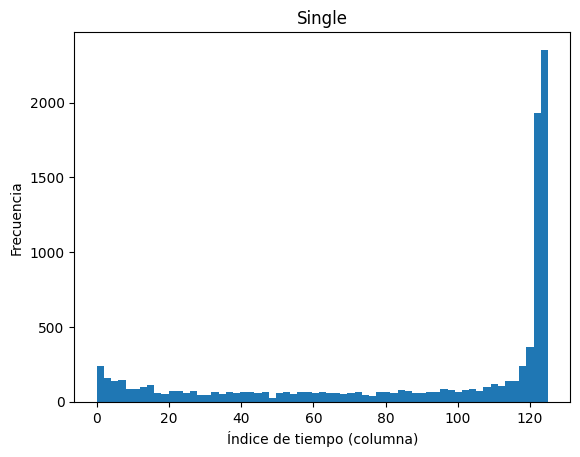

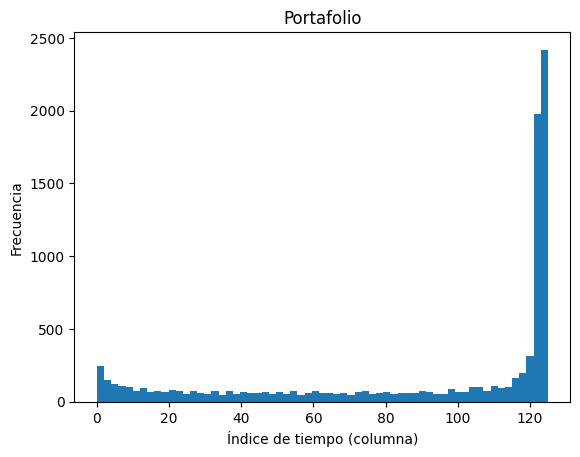

In [55]:
plot_hist_ejercicio(ejercicios, T_days, dt_days, "Single")
plot_hist_ejercicio(ejercicios_p, T_days, dt_days, "Portafolio")